In [1]:
import pandas as pd
import requests
import time
from datetime import datetime
import numpy as np

def get_binance_data(symbol="BTCUSDT", interval="1h", start_str="2022-01-01"):
    """
    Fetches historical kline (candlestick) data from Binance API.
    """
    url = "https://api.binance.com/api/v3/klines"
    
    # Convert date string to millisecond timestamp for Binance API
    start_ts = int(pd.to_datetime(start_str).timestamp() * 1000)
    all_data = []
    
    while True:
        # Define API parameters; limit 1000 is the max allowed per request
        params = {
            "symbol": symbol, 
            "interval": interval, 
            "startTime": start_ts, 
            "limit": 1000
        }
        
        # Execute GET request and parse JSON response
        response = requests.get(url, params=params)
        res = response.json()
        
        # Break loop if no more data is returned
        if not res: 
            break
        
        # Extract first 6 columns: Open time, Open, High, Low, Close, Volume
        df_chunk = pd.DataFrame(res).iloc[:, :6]
        all_data.append(df_chunk)
        
        # Update start_ts to the timestamp of the last received candle + 1ms
        start_ts = res[-1][0] + 1
        
        # If response has fewer than 1000 rows, we have reached the most recent data
        if len(res) < 1000: 
            break
            
        # Small delay to respect Binance API rate limits
        time.sleep(0.2)

    # Concatenate all data chunks into a single DataFrame
    df = pd.concat(all_data)
    
    # Assign standard financial column names
    df.columns = ['timestamp', 'open', 'high', 'low', 'close', 'volume']
    
    # Convert Unix timestamp (ms) to readable datetime objects
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    
    # Convert string values to float for numerical analysis
    for col in ['open', 'high', 'low', 'close', 'volume']:
        df[col] = df[col].astype(float)
        
    return df.reset_index(drop=True)

# --- Execution Phase ---
# Fetching data starting from January 1st, 2022
df = get_binance_data(start_str="2022-01-01")

# Saving raw data to local storage for persistence
df.to_csv("bitcoin_data.csv", index=False)
print("Data successfully downloaded and saved!")

# Display first few rows to verify structure
print(df.head())

Data successfully downloaded and saved!
            timestamp      open      high       low     close      volume
0 2022-01-01 00:00:00  46216.93  46731.39  46208.37  46656.13  1503.33095
1 2022-01-01 01:00:00  46656.14  46949.99  46574.06  46778.14   943.81539
2 2022-01-01 02:00:00  46778.14  46928.94  46721.96  46811.77   485.16860
3 2022-01-01 03:00:00  46811.77  46916.63  46760.12  46813.20   562.88971
4 2022-01-01 04:00:00  46813.21  46887.33  46591.23  46711.05   861.88389


In [2]:
print(df.tail())

                timestamp      open      high       low     close     volume
34827 2025-12-22 04:00:00  88774.13  89034.44  88712.11  88904.99  316.78715
34828 2025-12-22 05:00:00  88905.00  89000.00  88762.43  88831.34  260.18369
34829 2025-12-22 06:00:00  88831.34  89008.00  88730.07  88909.26  222.60970
34830 2025-12-22 07:00:00  88909.26  89200.00  88891.63  89170.10  491.12288
34831 2025-12-22 08:00:00  89170.10  89835.55  89093.44  89727.04  310.66396


In [3]:
import numpy as np

# --- Step 2: Data Integrity Audit ---

# Check for missing values in the dataset
print("Missing values count:")
print(df.isnull().sum())

# Ensure the timestamp is the index for time-series analysis
df.set_index('timestamp', inplace=True)

# Check for duplicates in the index
if df.index.duplicated().any():
    print("Duplicates found in index! Removing duplicates...")
    df = df[~df.index.duplicated(keep='first')]

# --- Step 3: Log-Returns Transformation ---

# Calculate Log-Returns using the 'close' price
# Formula: r_t = ln(P_t / P_{t-1})
df['log_return'] = np.log(df['close'] / df['close'].shift(1))

# Calculate Simple Returns (for comparison or specific metrics)
df['simple_return'] = df['close'].pct_change()

# Drop the first row as it will contain NaN after the shift operation
df.dropna(inplace=True)

print("\nData Transformation Complete.")
print(df[['close', 'log_return', 'simple_return']].head())

Missing values count:
timestamp    0
open         0
high         0
low          0
close        0
volume       0
dtype: int64

Data Transformation Complete.
                        close  log_return  simple_return
timestamp                                               
2022-01-01 01:00:00  46778.14    0.002612       0.002615
2022-01-01 02:00:00  46811.77    0.000719       0.000719
2022-01-01 03:00:00  46813.20    0.000031       0.000031
2022-01-01 04:00:00  46711.05   -0.002184      -0.002182
2022-01-01 05:00:00  47192.55    0.010255       0.010308


Number of detected outliers (Z > 3): 719


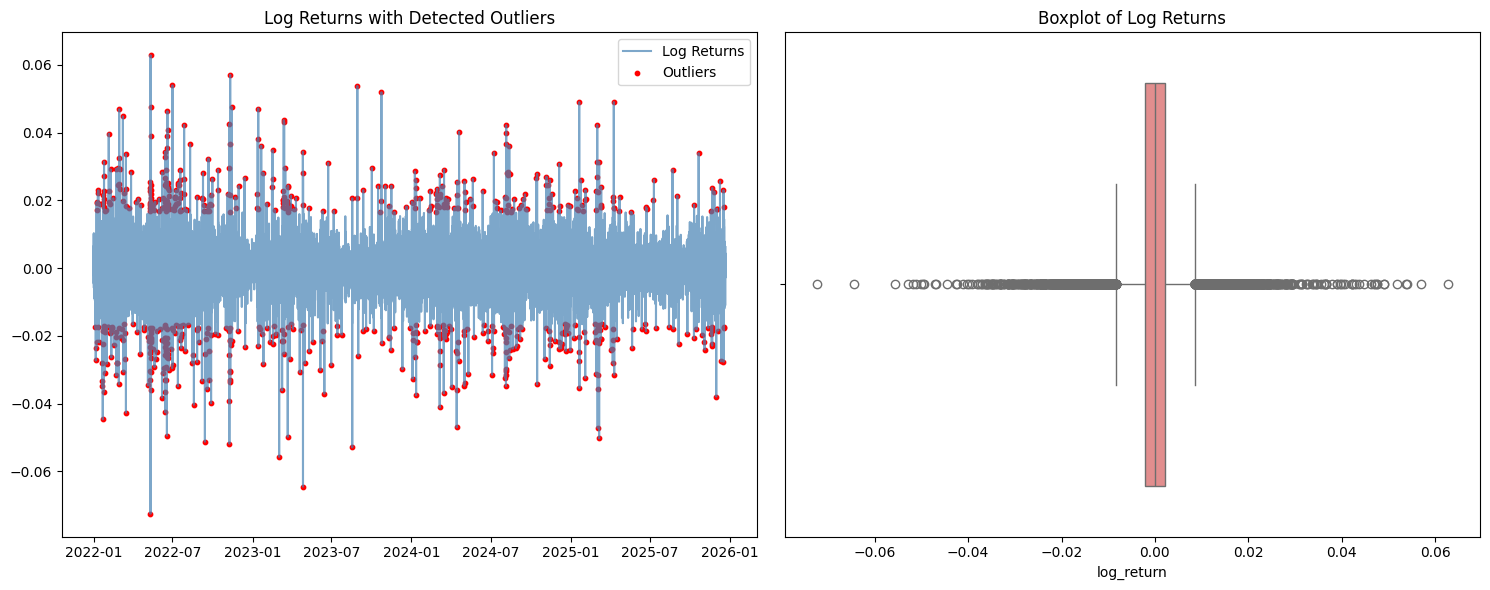

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- Step 4: Outlier Detection using Z-Score ---

# Calculate the mean and standard deviation of log returns
mean_ret = df['log_return'].mean()
std_ret = df['log_return'].std()

# Define a threshold for outliers (typically 3 standard deviations)
threshold = 3

# Identify outliers: points where the absolute Z-score is greater than 3
df['is_outlier'] = np.abs((df['log_return'] - mean_ret) / std_ret) > threshold

# Count the number of detected outliers
num_outliers = df['is_outlier'].sum()
print(f"Number of detected outliers (Z > 3): {num_outliers}")

# --- Step 5: Visualizing Outliers and Distribution ---

plt.figure(figsize=(15, 6))

# Plotting the log returns over time
plt.subplot(1, 2, 1)
plt.plot(df.index, df['log_return'], color='steelblue', label='Log Returns', alpha=0.7)
plt.scatter(df[df['is_outlier']].index, df[df['is_outlier']]['log_return'], 
            color='red', label='Outliers', s=10)
plt.title('Log Returns with Detected Outliers')
plt.legend()

# Plotting a boxplot to see the distribution of returns
plt.subplot(1, 2, 2)
sns.boxplot(x=df['log_return'], color='lightcoral')
plt.title('Boxplot of Log Returns')

plt.tight_layout()
plt.show()

In [5]:
from scipy.stats import skew, kurtosis

# --- Step 6: Calculating Descriptive Statistics and Moments ---

# Calculate basic statistics
stats_summary = df['log_return'].describe()

# Calculate Higher-Order Moments
# Skewness: measures asymmetry (Normal distribution = 0)
series_skew = skew(df['log_return'])

# Kurtosis: measures "tailedness" (Normal distribution = 3)
# We use Fisher’s definition (excess kurtosis), where Normal = 0
series_kurt = kurtosis(df['log_return'])

print("--- Descriptive Statistics ---")
print(stats_summary)
print(f"\nSkewness: {series_skew:.4f}")
print(f"Excess Kurtosis: {series_kurt:.4f}")

# Interpretation logic
if series_kurt > 0:
    print("\nObservation: High positive excess kurtosis indicates 'Fat Tails'.")
if abs(series_skew) > 0.1:
    print(f"Observation: Skewness of {series_skew:.4f} indicates asymmetrical distribution.")

--- Descriptive Statistics ---
count    34831.000000
mean         0.000019
std          0.005516
min         -0.072452
25%         -0.002051
50%          0.000045
75%          0.002173
max          0.062855
Name: log_return, dtype: float64

Skewness: -0.1706
Excess Kurtosis: 13.6270

Observation: High positive excess kurtosis indicates 'Fat Tails'.
Observation: Skewness of -0.1706 indicates asymmetrical distribution.


In [6]:
from statsmodels.tsa.stattools import adfuller, kpss

# --- Step 7: Stationarity Testing (ADF and KPSS) ---

def perform_stationarity_tests(series):
    # Augmented Dickey-Fuller Test
    print("Results of Augmented Dickey-Fuller Test:")
    adf_test = adfuller(series, autolag='AIC')
    print(f'ADF Statistic: {adf_test[0]:.4f}')
    print(f'p-value: {adf_test[1]:.4e}') # Using scientific notation for small p-values
    
    print("\n" + "-"*30 + "\n")
    
    # KPSS Test
    print("Results of KPSS Test:")
    # Regression='c' assumes stationarity around a constant
    kpss_test = kpss(series, regression='c', nlags="auto")
    print(f'KPSS Statistic: {kpss_test[0]:.4f}')
    print(f'p-value: {kpss_test[1]:.4f}')

# Run tests on log_return
perform_stationarity_tests(df['log_return'])

Results of Augmented Dickey-Fuller Test:
ADF Statistic: -36.8318
p-value: 0.0000e+00

------------------------------

Results of KPSS Test:
KPSS Statistic: 0.3079
p-value: 0.1000


C:\Users\User\AppData\Local\Temp\ipykernel_8912\1612427778.py:17: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_test = kpss(series, regression='c', nlags="auto")


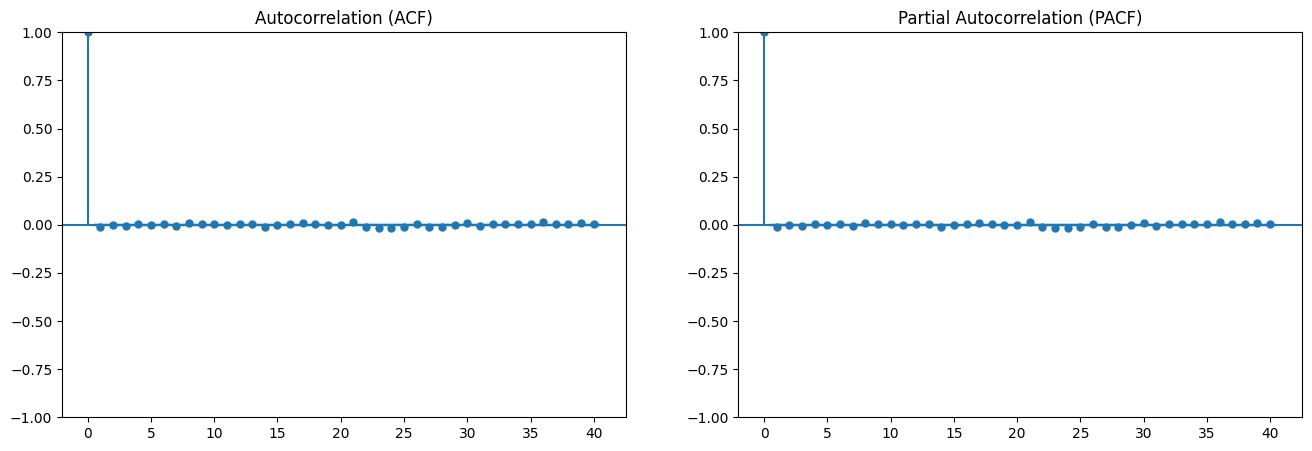

Hurst Exponent: -0.0001
Market characteristic: Mean-reverting (Anti-persistent)


In [7]:
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# --- Step 8: Autocorrelation Analysis ---

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# ACF measures the correlation between the series and its lagged values
plot_acf(df['log_return'], lags=40, ax=axes[0], title='Autocorrelation (ACF)')

# PACF measures the partial correlation (controlling for intermediate lags)
plot_pacf(df['log_return'], lags=40, ax=axes[1], title='Partial Autocorrelation (PACF)')

plt.show()

# --- Step 9: Hurst Exponent Calculation ---

def hurst_exponent(series):
    """
    Calculates the Hurst Exponent to estimate the memory of the time series.
    """
    lags = range(2, 100)
    tau = [np.sqrt(np.std(np.subtract(series[lag:], series[:-lag]))) for lag in lags]
    poly = np.polyfit(np.log(lags), np.log(tau), 1)
    return poly[0] * 2.0

h_exp = hurst_exponent(df['log_return'].values)
print(f"Hurst Exponent: {h_exp:.4f}")

if h_exp < 0.5:
    print("Market characteristic: Mean-reverting (Anti-persistent)")
elif h_exp > 0.5:
    print("Market characteristic: Trending (Persistent)")
else:
    print("Market characteristic: Random Walk")

Engle's ARCH Test p-value: 0.0000e+00
Result: Strong Volatility Clustering detected (ARCH effects).
Conclusion: Models that account for volatility (like Transformers or GARCH) are justified.


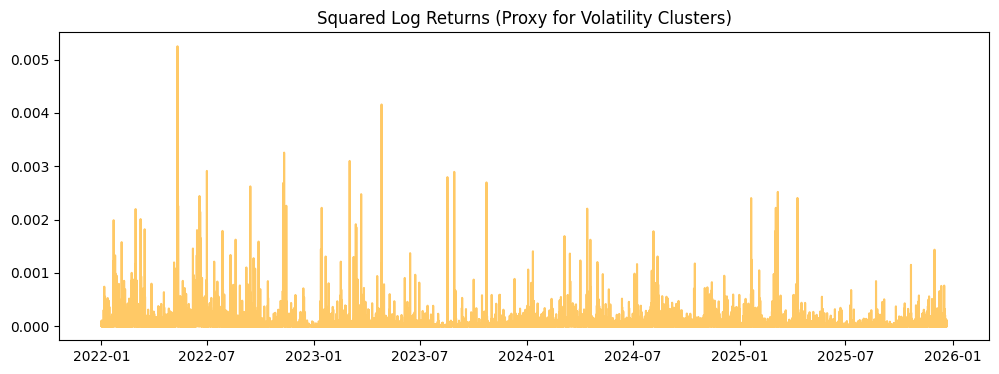

In [8]:
from statsmodels.stats.diagnostic import het_arch

# --- Step 10: Testing for Volatility Clustering (ARCH Effect) ---

# We test the squared residuals to see if variance is constant
# If p-value < 0.05, it confirms the presence of ARCH effects
arch_test = het_arch(df['log_return'])
print(f"Engle's ARCH Test p-value: {arch_test[1]:.4e}")

if arch_test[1] < 0.05:
    print("Result: Strong Volatility Clustering detected (ARCH effects).")
    print("Conclusion: Models that account for volatility (like Transformers or GARCH) are justified.")

# Visualizing squared returns to see clusters
plt.figure(figsize=(12, 4))
plt.plot(df.index, df['log_return']**2, color='orange', alpha=0.6)
plt.title('Squared Log Returns (Proxy for Volatility Clusters)')
plt.show()

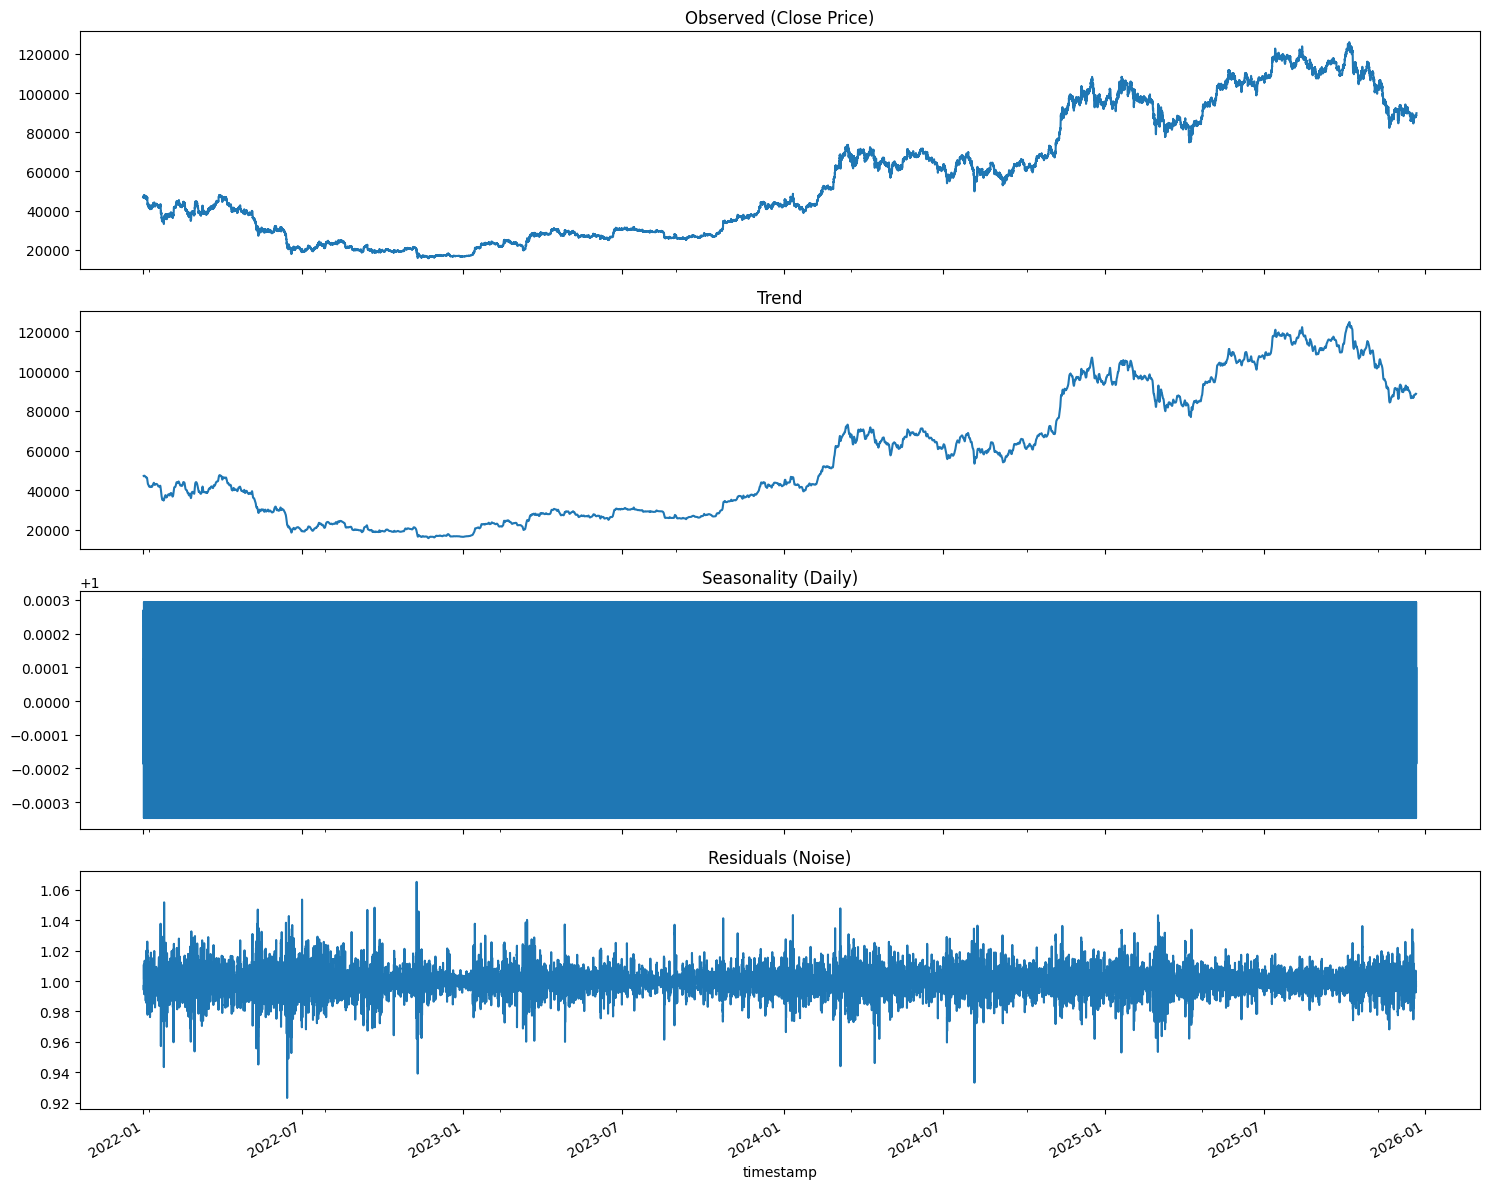

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose

# --- Step 11: Seasonal Decomposition ---
result = seasonal_decompose(df['close'], model='multiplicative', period=24)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 12), sharex=True)
result.observed.plot(ax=ax1, title='Observed (Close Price)')
result.trend.plot(ax=ax2, title='Trend')
result.seasonal.plot(ax=ax3, title='Seasonality (Daily)')
result.resid.plot(ax=ax4, title='Residuals (Noise)')

plt.tight_layout()
plt.show()

In [10]:
df.to_csv('data_processed_nb01.csv')
print("Success! File 'data_processed_nb01.csv' has been created in your folder.")

Success! File 'data_processed_nb01.csv' has been created in your folder.
